# Personal Stats

contents and filters:
- most protocols are in few committees - **keep only top committees**.
- committees appear with different names - **manually normalize all committees names**.
- reported dates are inconsistent with knesset number for old knessets, thus **remove any knesset < 16**.
- many protocols are almost empty - only title with neither contents nor speakers. **remove protocols with up to 5 NA body sections**.
- in the bottom: the top attendees in each committee - **attendances over years & knessets**.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pickle
import random
from pathlib import Path
from time import time
from datetime import datetime
from tqdm import tqdm, tnrange, tqdm_notebook
from pprint import pprint
from warnings import warn
from datetime import datetime
import itertools
from collections import Counter, OrderedDict
from bidi import algorithm as bidi
from hebrew_stopwords import hebrew_stopwords
import Parser

In [114]:
mpl.rcParams.update({'font.size': 18})

## Load data

In [4]:
%%time
DATA = Path('Data')
meta = pd.read_csv(DATA/'meta.csv')
df = pd.read_csv(DATA/'data.csv')

Wall time: 1min 10s


In [5]:
if len(meta)!=len(np.unique(df.ID)):
    warn(f'Inconsistent dimensions! {len(meta):d}!={len(np.unique(df.ID)):d}')

## Consider top committees and merge similar names

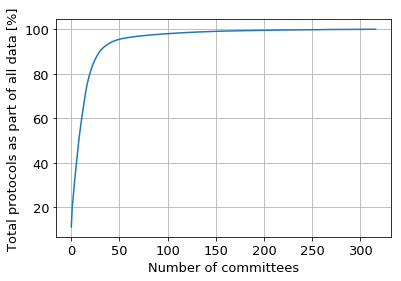

In [6]:
plt.plot(100*np.cumsum(sorted(Counter(meta.committee_name).values())[::-1])/np.sum((sorted(Counter(meta.committee_name).values())[::-1])))
plt.xlabel('Number of committees')
plt.ylabel('Total protocols as part of all data [%]')
plt.grid()

['הכספים',
 'הכלכלה',
 'לענייני ביקורת המדינה',
 'הכנסת',
 'החוקה, חוק ומשפט',
 'הפנים ואיכות הסביבה',
 'העבודה והרווחה',
 'העבודה, הרווחה והבריאות',
 'ועדת הכספים',
 'החוקה חוק ומשפט',
 'החינוך והתרבות',
 'ועדת הכלכלה',
 'הפנים והגנת הסביבה',
 'ועדת העבודה, הרווחה והבריאות',
 'ועדת הפנים והגנת הסביבה',
 'החינוך, התרבות והספורט',
 'ועדת החוקה, חוק ומשפט',
 'החינוך התרבות והספורט',
 'העליה והקליטה',
 'ועדת החינוך, התרבות והספורט',
 'ועדת הכנסת',
 'העלייה, הקליטה והתפוצות',
 'הוועדה לענייני ביקורת המדינה',
 'ועדת העלייה, הקליטה והתפוצות',
 'הוועדה לקידום מעמד האישה ולשוויון מגדרי']

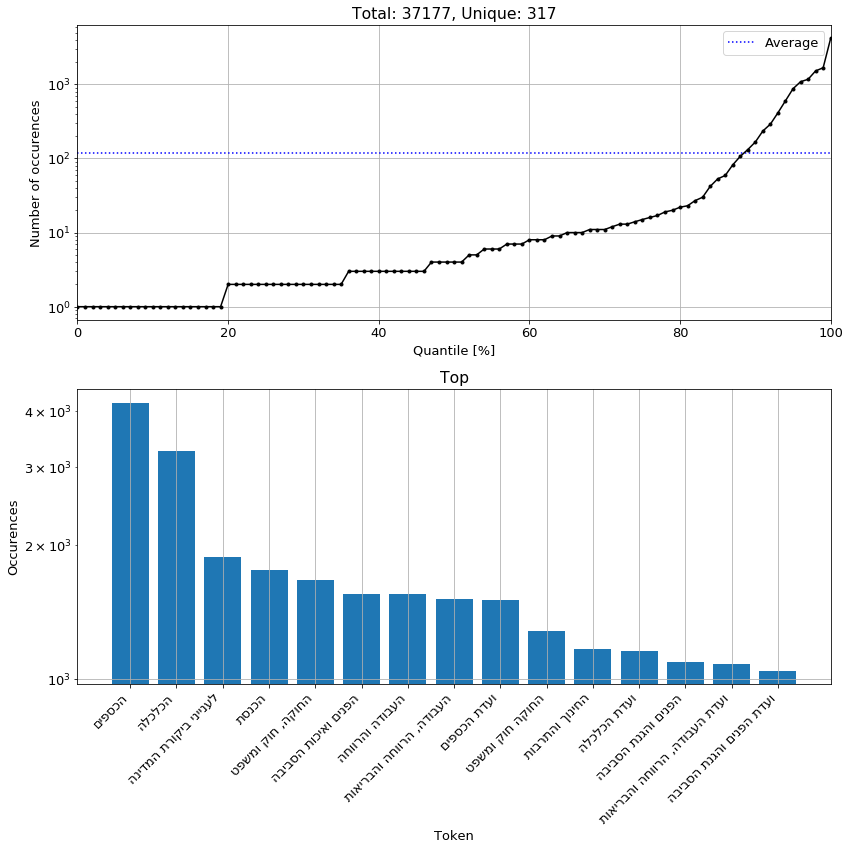

In [7]:
meta['merged_name'] = meta.committee_name.copy()
Parser.show_freqs(meta.merged_name, show_tail=0)[0][:25]

C:\Users\idogr\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


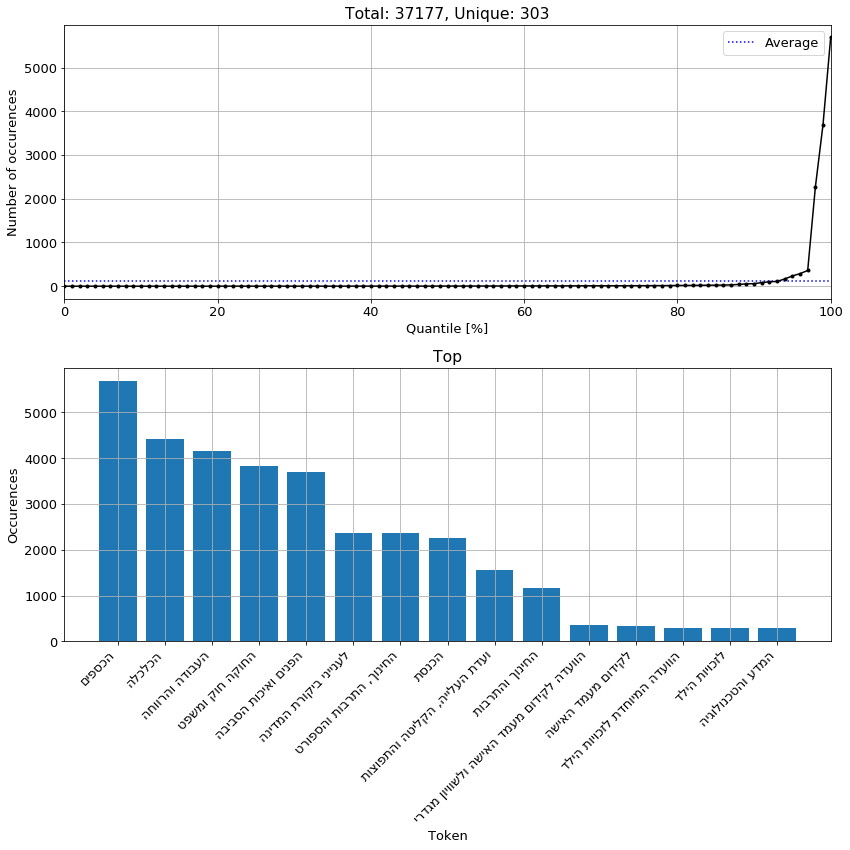

In [8]:
def merge_names(d, name, to_merge):
    d.merged_name[d.merged_name.isin(to_merge)] = name

merge_names(meta, 'העבודה והרווחה',('ועדת העבודה, הרווחה והבריאות','העבודה, הרווחה והבריאות'))
merge_names(meta, 'הכספים', ('ועדת הכספים',))
merge_names(meta, 'הכלכלה', ('ועדת הכלכלה',))
merge_names(meta, 'החוקה חוק ומשפט', ('החוקה, חוק ומשפט','ועדת החוקה, חוק ומשפט'))
merge_names(meta, 'הפנים ואיכות הסביבה', ('הפנים והגנת הסביבה','ועדת הפנים והגנת הסביבה'))
merge_names(meta, 'החינוך, התרבות והספורט', ('ועדת החינוך, התרבות והספורט','החינוך התרבות והספורט'))
merge_names(meta, 'הכנסת', ('ועדת הכנסת',))
merge_names(meta, 'ועדת העלייה, הקליטה והתפוצות', ('העלייה, הקליטה והתפוצות','העליה והקליטה'))
merge_names(meta, 'לענייני ביקורת המדינה', ('הוועדה לענייני ביקורת המדינה',))

top_names = Parser.show_freqs(meta.merged_name, show_tail=0, logscale=0)[0][:11]

In [9]:
mm = meta[meta.merged_name.isin(top_names)]
print(mm.shape)

(31899, 26)


## Some committees over time stats

C:\Users\idogr\Anaconda3\lib\site-packages\seaborn\categorical.py:598: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
C:\Users\idogr\Anaconda3\lib\site-packages\seaborn\categorical.py:826: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


Committee ID is a serial with no gaps in 100% of rows.
Constant cols:	['GroupTypeID', 'GroupTypeDesc', 'ApplicationID', 'ApplicationDesc', 'protocol_extension', 'error']


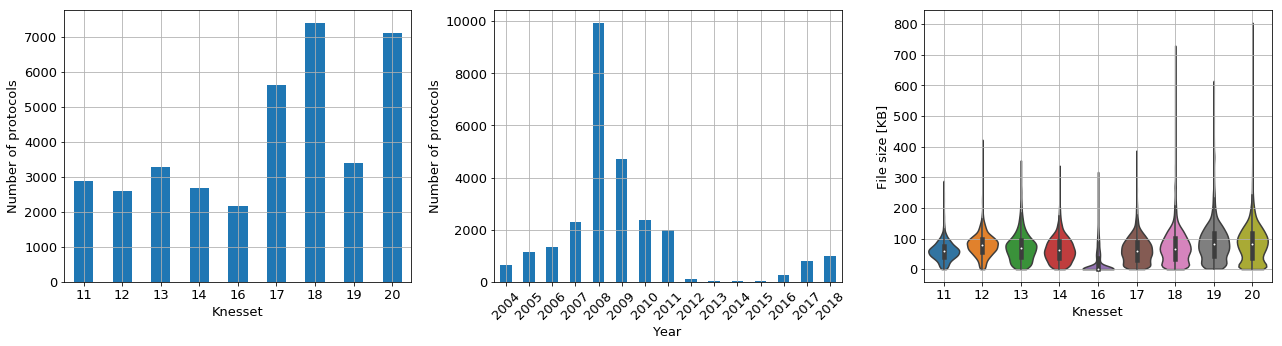

In [10]:
_, axs = plt.subplots(1,3, figsize=(18,5))

ax = axs[0]
meta.ID.groupby(meta.KnessetNum).count().plot(kind='bar', ax=ax)
ax.set_xlabel('Knesset')
ax.set_ylabel('Number of protocols')
ax.tick_params(axis='x', rotation=0)
ax.grid()

ax = axs[1]
meta.ID.groupby([s[:4] if type(s) is str else None for s in meta.date]).count().plot(kind='bar', ax=ax)
ax.set_xlabel('Year')
ax.set_ylabel('Number of protocols')
ax.tick_params(axis='x', rotation=45)
ax.grid()

ax = axs[2]
sns.violinplot(x=meta.KnessetNum, y=meta.filesize/1024, scale='width', cut=0)
ax.set_xlabel('Knesset')
ax.set_ylabel('File size [KB]')
ax.tick_params(axis='x', rotation=0)
ax.grid()

plt.tight_layout()

print(f'Committee ID is a serial with no gaps in {100 * Counter(np.diff(meta.iloc[:,0]))[1] / len(meta):.0f}% of rows.')
print(f'Constant cols:\t',end='')
print([c for c in meta.columns if len(meta[c].unique())==1])

C:\Users\idogr\Anaconda3\lib\site-packages\seaborn\categorical.py:598: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
C:\Users\idogr\Anaconda3\lib\site-packages\seaborn\categorical.py:826: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


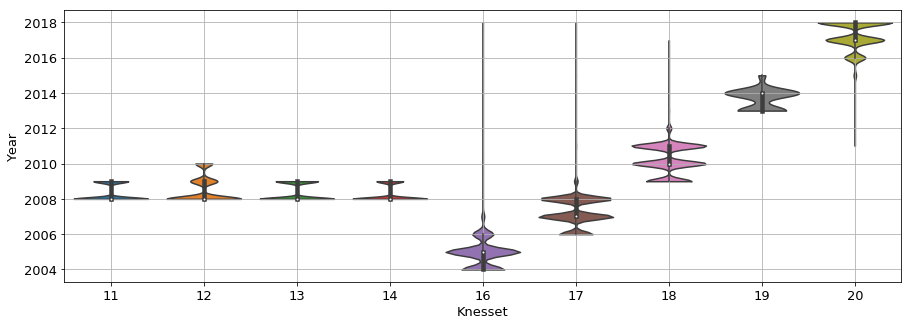

In [11]:
plt.figure(figsize=(15,5))
sns.violinplot(x=meta[meta.date.apply(lambda d: type(d) is str)].KnessetNum,
               y=meta[meta.date.apply(lambda d: type(d) is str)].date.apply(lambda d: int(d[:4])), scale='width', cut=0)
plt.xlabel('Knesset')
plt.ylabel('Year')
#plt.xticks(rotation=45)
plt.grid()

In [12]:
mm = mm[mm.KnessetNum>=16]
mm.shape

(20579, 26)

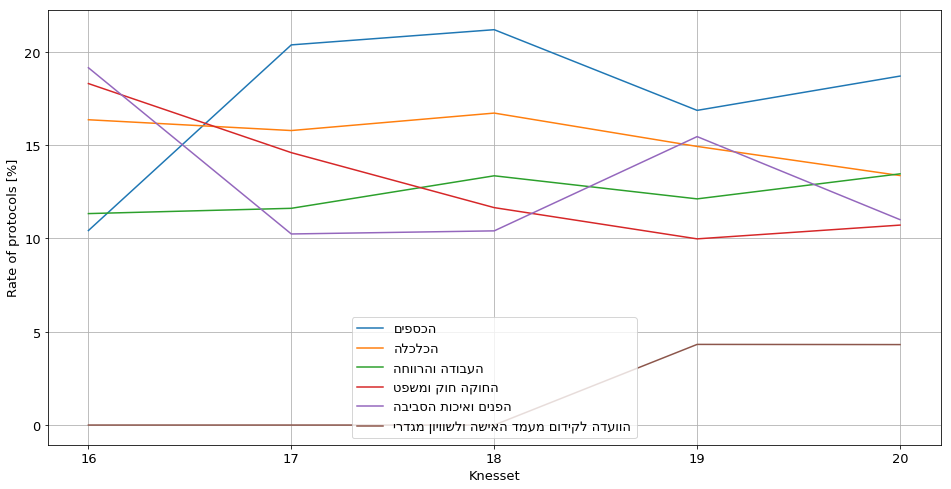

In [13]:
plt.figure(figsize=(16,8))
for tnm in top_names[:5]+[top_names[-1]]:
    plt.plot(mm.merged_name.groupby(mm.KnessetNum).apply(lambda nm: 100*np.sum(nm==tnm)/len(nm)),
             label=bidi.get_display(tnm))
plt.xlabel('Knesset')
plt.ylabel('Rate of protocols [%]')
plt.xticks([16,17,18,19,20])
plt.grid()
plt.legend()

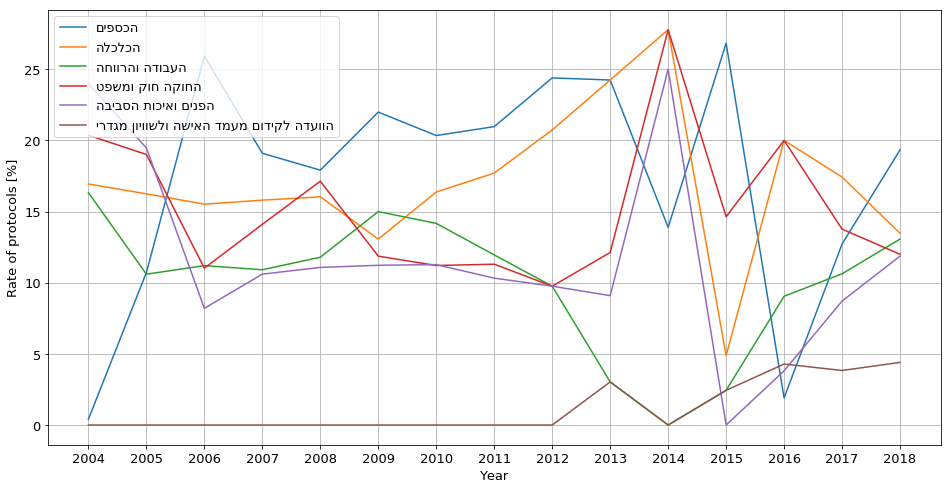

In [14]:
plt.figure(figsize=(16,8))
for tnm in top_names[:5]+[top_names[-1]]:
    plt.plot(mm[[type(d) is str for d in mm.date]].merged_name.groupby(mm.date.apply(lambda d: str(d)[:4])).apply(
        lambda nm: 100*np.sum(nm==tnm)/len(nm)),
             label=bidi.get_display(tnm))
plt.xlabel('Year')
plt.ylabel('Rate of protocols [%]')
#plt.xticks(rotation=40)
plt.grid()
plt.legend()

## Top speaker stats (NOT INTERESTING)

In [15]:
cc = mm[mm.merged_name=='הכלכלה']
cc.shape

(3156, 26)

In [16]:
df[df.ID==cc.ID.values[20]]

,Unnamed: 0,header,body,ID
1581,1581,NaN,knesset\r\n\r\n2004-11-02Liraz\r\n\r\n\r\n\r\n...,71483.0
1582,1582,נכחו:,NaN,71483.0
1583,1583,חברי הוועדה,NaN,71483.0
1584,1584,חברי הכנסת,NaN,71483.0
1585,1585,מוזמנים,NaN,71483.0
1586,1586,יועצת משפטית,NaN,71483.0
1587,1587,מנהלת הוועדה,"סדר היום : פריט ועדה תקנות, תקנות להסדרת הפיקו...",71483.0


In [17]:
cc = cc[cc.ID.isin([ID for ID in cc.ID if df[df.ID==ID].body.apply(lambda b: type(b) is str).sum()>5])]
cc.shape

(2914, 26)

In [18]:
df[df.ID==cc.ID.values[0]]

,Unnamed: 0,header,body,ID
2045,2045,NaN,v_kalkala_idit\r\n\r\n2005-11-17Liraz\r\n\r\n\...,71955.0
2046,2046,נכחו,NaN,71955.0
2047,2047,חברי הוועדה,"שלום שמחון - היו""ר\r\n\r\nמיכאל גורלובסקי\r\n\...",71955.0
2048,2048,מוזמנים,"עו""ד מלי סיטון – יועצת משפטית, משרד התחבורה\r\...",71955.0
2049,2049,"היו""ר שלום שמחון",אני פותח את הישיבה. על סדר היום - הצעת חוק רשו...,71955.0
2050,2050,אתי בנדלר,"בעניין האגרות, אין סתירה עם חוק יסודות התקציב.",71955.0
2051,2051,שאול מרידור,"הממשלה מתנגדת לאגרות ייעודיות, אם הוועדה תחליט...",71955.0
2052,2052,"היו""ר שלום שמחון","אישרנו זאת. אם אתם רוצים, תגישו הסתייגות.",71955.0
2053,2053,אתי בנדלר,"הסתייגויות אפשר להגיש עד סוף השבוע הזה, בחתימת...",71955.0
2054,2054,שאול מרידור,"אגרות הקיימות היום במינהל התעופה ועדכונן, זה ע...",71955.0


C:\Users\idogr\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3443: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=1.0, top=1.0
  'bottom=%s, top=%s') % (bottom, top))


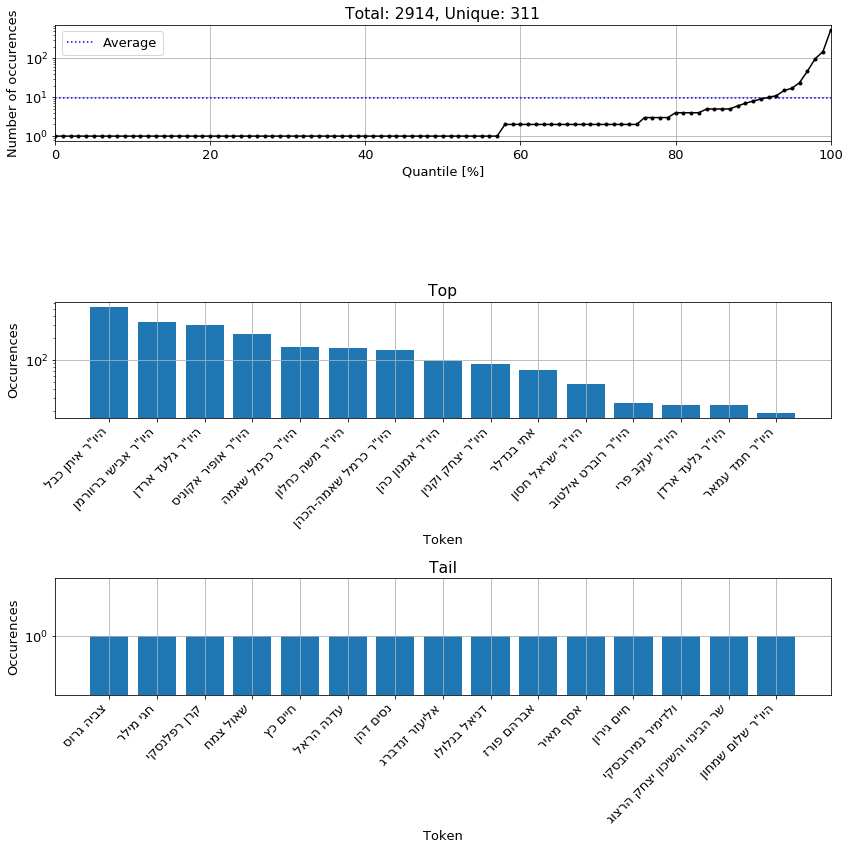

In [19]:
cc['top_speaker'] = [df[df.ID==ID].header.mode().values[0] for ID in cc.ID]
cc['top_speaker'].fillna('', inplace=True)
null = Parser.show_freqs(cc.top_speaker)

In [20]:
top_speakers_in_calcala = null[0][:7]
top_speakers_in_calcala

['היו"ר איתן כבל',
 'היו"ר אבישי ברוורמן',
 'היו"ר גלעד ארדן',
 'היו"ר אופיר אקוניס',
 'היו"ר כרמל שאמה',
 'היו"ר משה כחלון',
 'היו"ר כרמל שאמה-הכהן']

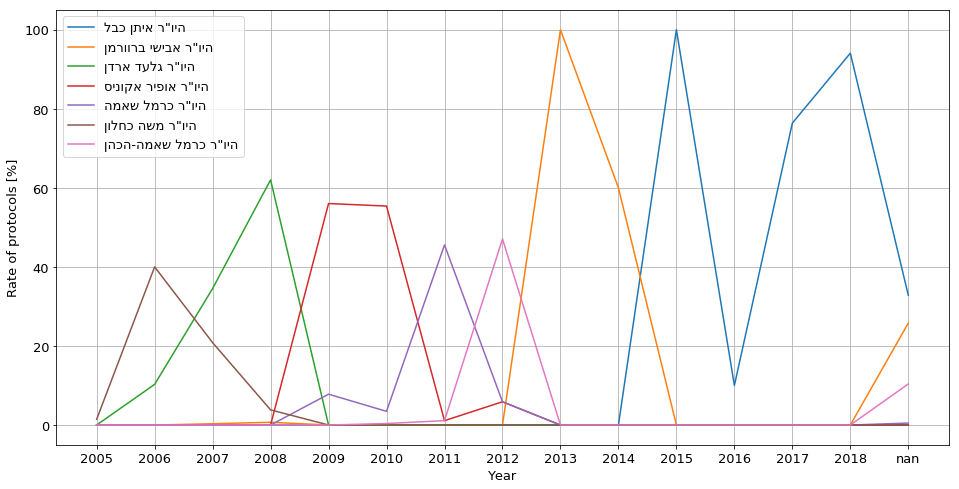

In [21]:
plt.figure(figsize=(16,8))
for tnm in top_speakers_in_calcala:
    plt.plot(cc.top_speaker.groupby(cc.date.apply(lambda d: str(d)[:4])).apply(
        lambda nm: 100*np.sum(nm==tnm)/len(nm)),
             label=bidi.get_display(tnm))
plt.xlabel('Year')
plt.ylabel('Rate of protocols [%]')
#plt.xticks(rotation=40)
plt.grid()
plt.legend()

## Analyze speakers df

In [22]:
p = pd.read_pickle('Data/merged_memebrs_df.pkl')
p.head()

,header,ID,CommitteeSessionID,committee_name,lemmas
0,NaN,71333.0,65782,הכנסת,"{'JJ': ['פטור', 'משפטי'], 'CD': [], 'NN': ['עב..."
1,סדר היום,71333.0,65782,הכנסת,"{'JJ': ['פטור', 'משפטי'], 'CD': [], 'NN': ['עב..."
2,"היו""ר רוני בר-און",71333.0,65782,הכנסת,"{'JJ': ['פטור', 'משפטי'], 'CD': [], 'NN': ['עב..."
3,זהבה גלאון,71333.0,65782,הכנסת,"{'JJ': ['פטור', 'משפטי'], 'CD': [], 'NN': ['עב..."
4,"היו""ר רוני בר-און",71333.0,65782,הכנסת,"{'JJ': ['פטור', 'משפטי'], 'CD': [], 'NN': ['עב..."


In [23]:
p['merged_name'] = p.committee_name.copy()

def merge_names(d, name, to_merge):
    d.merged_name[d.merged_name.isin(to_merge)] = name

merge_names(p, 'העבודה והרווחה',('ועדת העבודה, הרווחה והבריאות','העבודה, הרווחה והבריאות'))
merge_names(p, 'הכספים', ('ועדת הכספים',))
merge_names(p, 'הכלכלה', ('ועדת הכלכלה',))
merge_names(p, 'החוקה חוק ומשפט', ('החוקה, חוק ומשפט','ועדת החוקה, חוק ומשפט'))
merge_names(p, 'הפנים ואיכות הסביבה', ('הפנים והגנת הסביבה','ועדת הפנים והגנת הסביבה'))
merge_names(p, 'החינוך, התרבות והספורט', ('ועדת החינוך, התרבות והספורט','החינוך התרבות והספורט'))
merge_names(p, 'הכנסת', ('ועדת הכנסת',))
merge_names(p, 'ועדת העלייה, הקליטה והתפוצות', ('העלייה, הקליטה והתפוצות','העליה והקליטה'))
merge_names(p, 'לענייני ביקורת המדינה', ('הוועדה לענייני ביקורת המדינה',))

p.fillna('', inplace=True)

C:\Users\idogr\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [66]:
dates = {ID: dt for ID,dt in zip(meta.ID,meta.date) if type(dt) is str and dt}

Wall time: 38.4 s


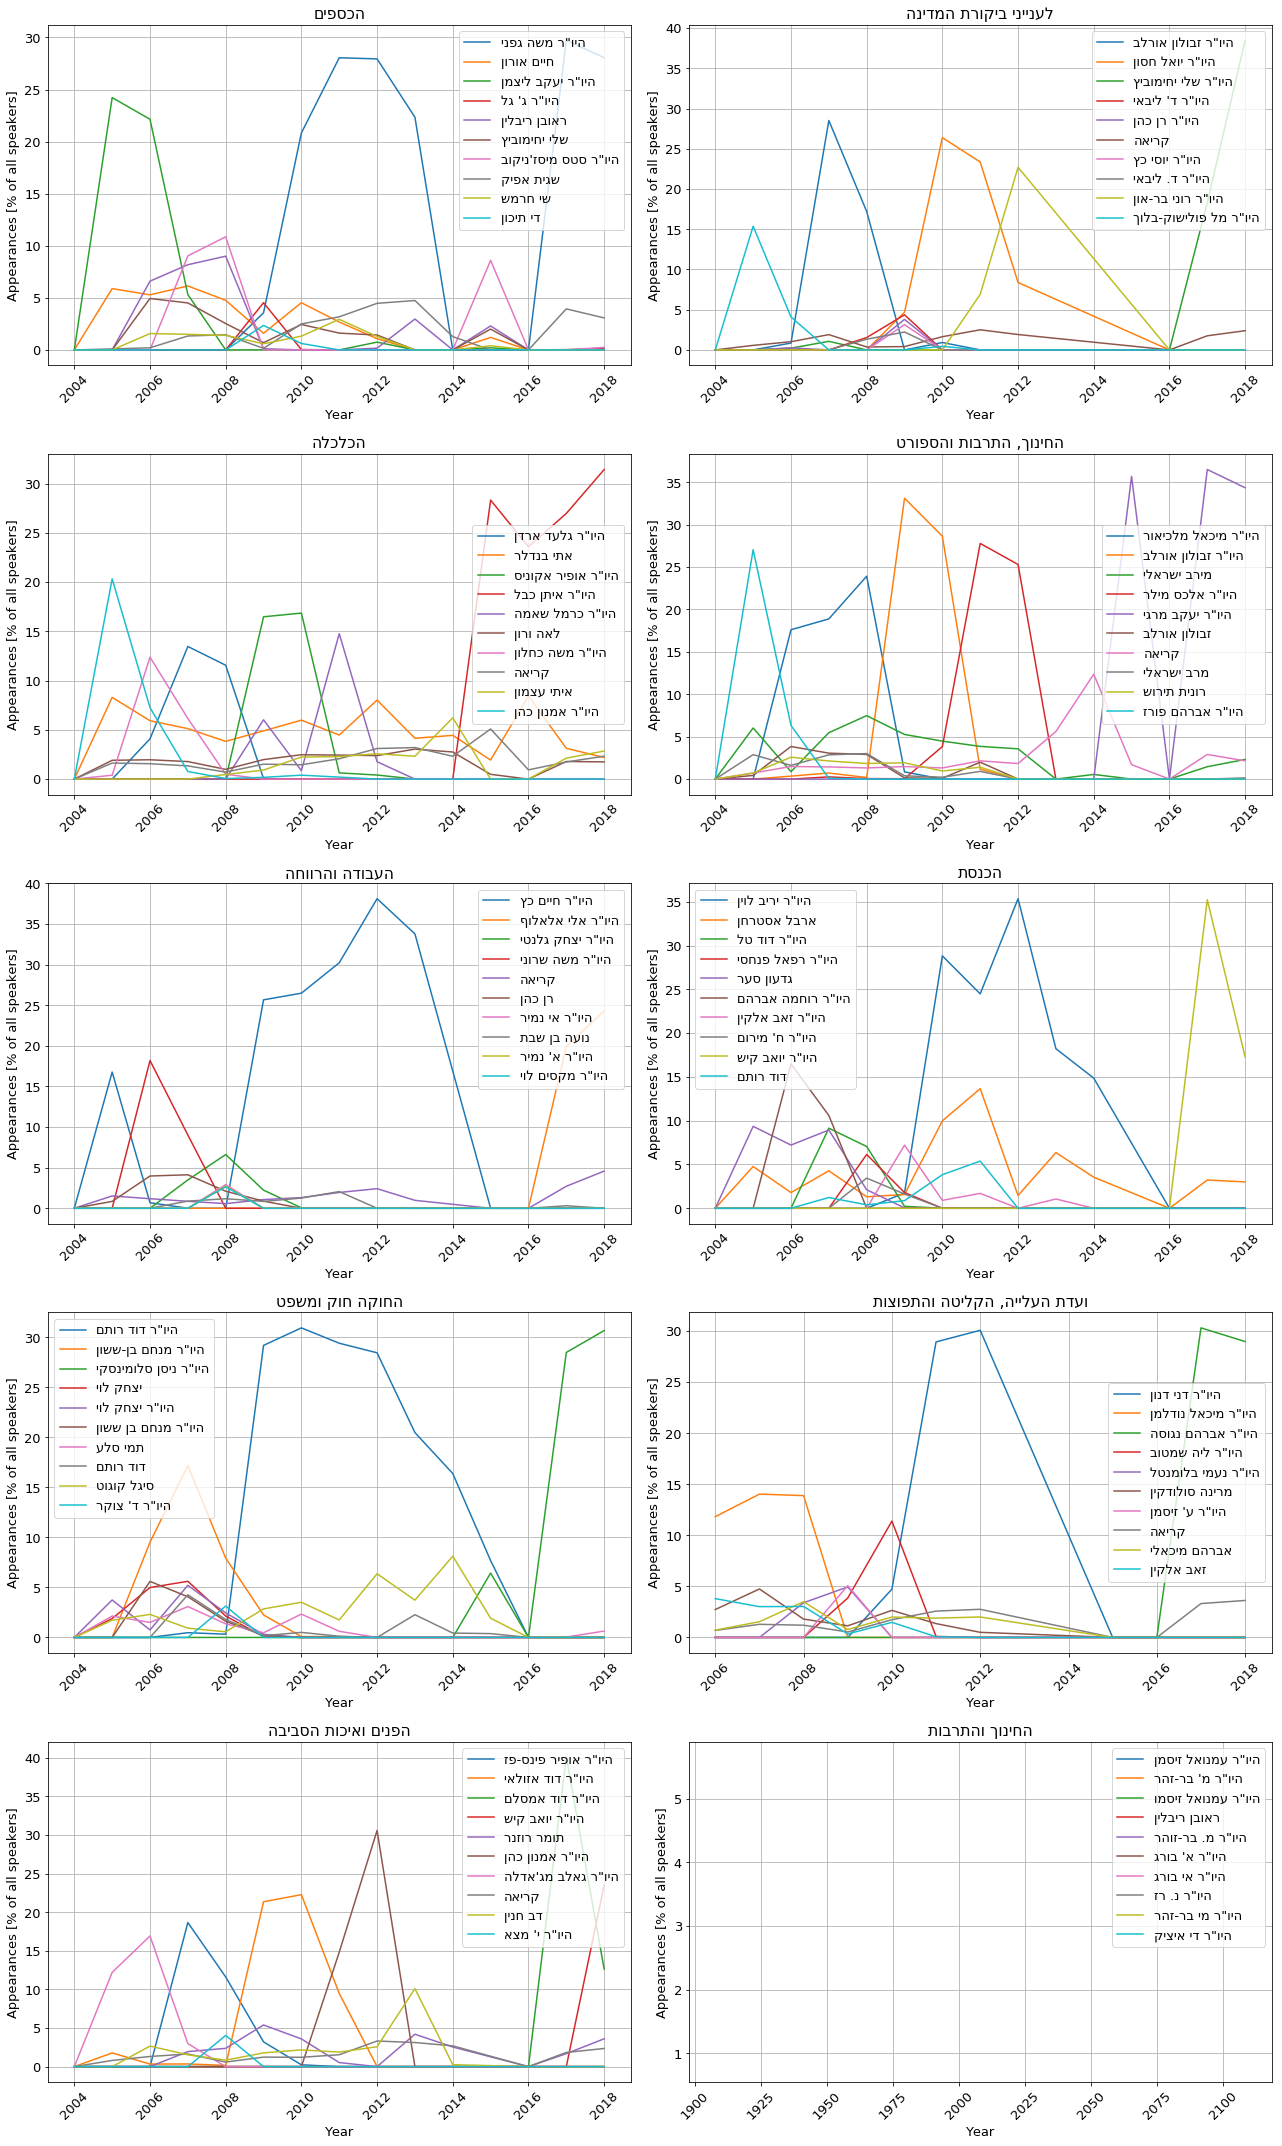

In [84]:
%%time

_, axs = plt.subplots(5,2, figsize=(18,30))

for i,tnm in enumerate(top_names[:10]):
    ax = axs[i%5,i//5]
    tt = p[p.merged_name==tnm]
    tt = tt[tt.ID.isin(dates)]
    ts = OrderedDict(sorted(Counter(tt.header).items(),
                            key=lambda kv: kv[1], reverse=1))
    ts = list(ts.keys())[:20]
    ts = [t for t in ts if len(t)>2 and t not in ('חברי הוועדה', 'נכחו:', 'נכחו', 'מוזמנים', 'חברי הכנסת','סדר היום')][:10]
    for s in ts:
        tmp = tt.header.groupby(tt.ID.apply(lambda i:str(dates[i])[:4])).apply(lambda h: 100*np.sum(h==s)/len(h)).sort_index()
        ax.plot([int(i) for i in tmp.index], tmp, label=bidi.get_display(s))
    ax.set_title(bidi.get_display(tnm))
    ax.set_xlabel('Year')
    ax.set_ylabel('Appearances [% of all speakers]')
    ax.tick_params(axis='x', rotation=45)
    ax.grid()
    ax.legend()
    
plt.tight_layout()

In [85]:
knesset = {ID: k for ID,k in zip(meta.ID,meta.KnessetNum)}

Wall time: 36 s


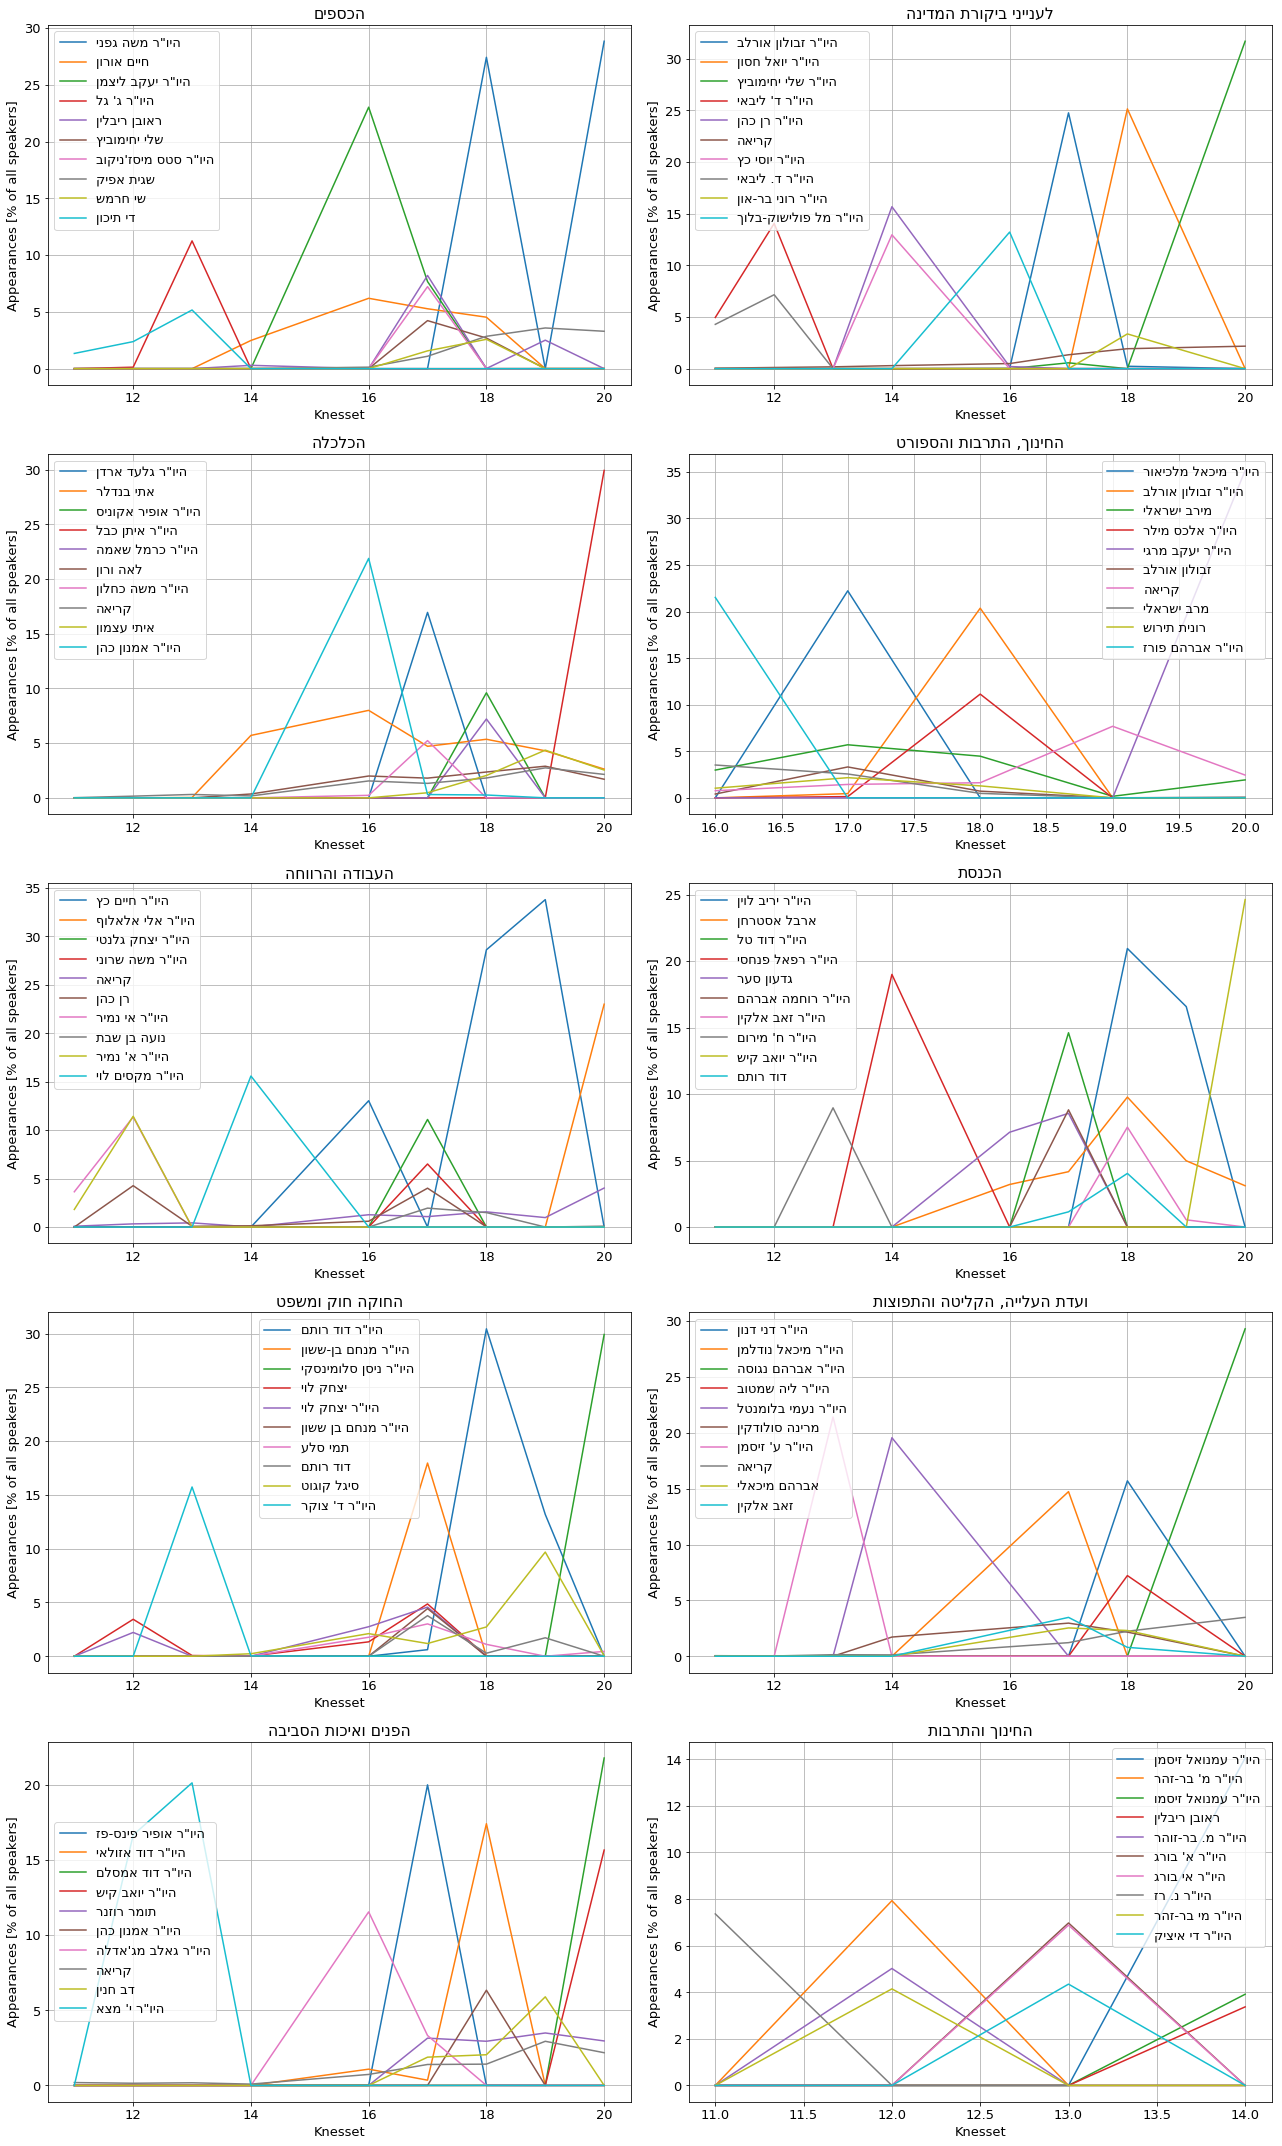

In [89]:
%%time

_, axs = plt.subplots(5,2, figsize=(18,30))

for i,tnm in enumerate(top_names[:10]):
    ax = axs[i%5,i//5]
    tt = p[p.merged_name==tnm]
    tt = tt[tt.ID.isin(dates)]
    ts = OrderedDict(sorted(Counter(tt.header).items(),
                            key=lambda kv: kv[1], reverse=1))
    ts = list(ts.keys())[:20]
    ts = [t for t in ts if len(t)>2 and t not in ('חברי הוועדה', 'נכחו:', 'נכחו', 'מוזמנים', 'חברי הכנסת','סדר היום')][:10]
    for s in ts:
        tmp = tt.header.groupby(tt.ID.apply(lambda i:knesset[i])).apply(lambda h: 100*np.sum(h==s)/len(h)).sort_index()
        ax.plot([int(i) for i in tmp.index], tmp, label=bidi.get_display(s))
    ax.set_title(bidi.get_display(tnm))
    ax.set_xlabel('Knesset')
    ax.set_ylabel('Appearances [% of all speakers]')
    ax.tick_params(axis='x', rotation=0)
    ax.grid()
    ax.legend()
    
plt.tight_layout()

In [101]:
p.drop_duplicates(('header','ID'),inplace=True)
p.shape

(746817, 6)

Wall time: 2.71 s


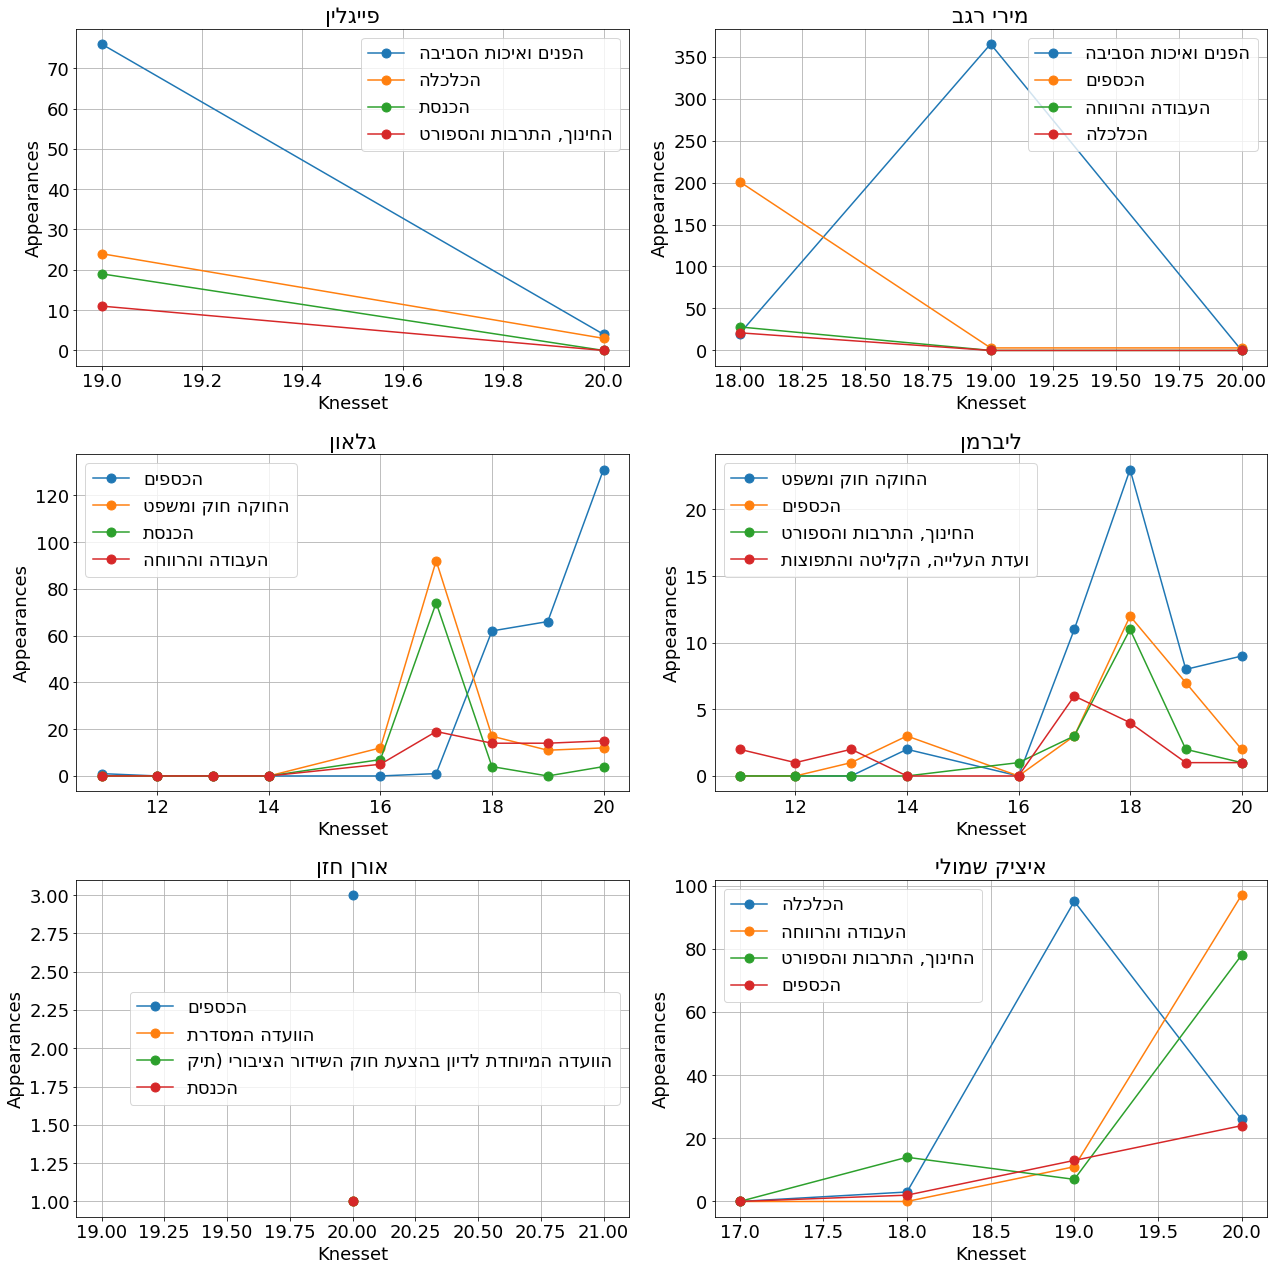

In [115]:
%%time

speakers = ('פייגלין','מירי רגב','גלאון','ליברמן', 'אורן חזן','איציק שמולי')

_, axs = plt.subplots(3,2, figsize=(18,18))

for i,tnm in enumerate(speakers):
    ax = axs[i//2,i%2]
    tt = p[[tnm in h for h in p.header]]
    ts = OrderedDict(sorted(Counter(tt.merged_name).items(),
                            key=lambda kv: kv[1], reverse=1))
    ts = list(ts.keys())[:4]
    for s in ts:
        tmp = tt.merged_name.groupby(tt.ID.apply(lambda i:knesset[i])).apply(lambda h: np.sum(h==s)).sort_index()
        ax.plot([int(i) for i in tmp.index], tmp, '.-', markersize=18, label=bidi.get_display(s[:50]))
    ax.set_title(bidi.get_display(tnm))
    ax.set_xlabel('Knesset')
    ax.set_ylabel('Appearances')
    ax.tick_params(axis='x', rotation=0)
    ax.grid()
    ax.legend()
    
plt.tight_layout()